In [50]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from math import sqrt


把科學記號改成十進位

In [51]:
import pandas as pd
import decimal

# 讀取CSV文件，確保資料的精度
df = pd.read_csv('data/combined_dataset_all.csv', encoding='utf-8-sig', dtype=str)

# 將Chlorophyll欄位轉換為不使用科學記號的小數形式
df['Chlorophyll'] = df['Chlorophyll'].apply(lambda x: format(decimal.Decimal(x), 'f'))

# 輸出篩選後的結果到原本的CSV文件
df.to_csv('data/combined_dataset_all.csv', index=False, encoding='utf-8-sig')


先取出100000筆來train看看

In [52]:
import pandas as pd

# 讀取CSV文件
combined_df = pd.read_csv("data/combined_dataset_all.csv")

# 隨機選取10000筆資料
sampled_df = combined_df.sample(n=100000, random_state=1)

# 保存為新的CSV文件
sampled_df.to_csv("data/train_combined_dataset_all.csv", index=False)

print("已成功從 combined_dataset_all.csv 中選取 100000 筆資料並保存到 data/train_combined_dataset_all.csv")


已成功從 combined_dataset_all.csv 中選取 100000 筆資料並保存到 data/train_combined_dataset_all.csv


In [53]:
data = pd.read_csv("data/train_combined_dataset_all.csv")

In [54]:
data.info()
data.describe()
data.shape
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   GOCI2_Latitude      100000 non-null  float64
 1   GOCI2_Longitude     100000 non-null  float64
 2   Himawari_Latitude   100000 non-null  float64
 3   Himawari_Longitude  100000 non-null  float64
 4   Chlorophyll         100000 non-null  float64
 5   Albedo_01           100000 non-null  float64
 6   Albedo_02           100000 non-null  float64
 7   Albedo_03           100000 non-null  float64
 8   Albedo_04           100000 non-null  float64
dtypes: float64(9)
memory usage: 6.9 MB
Index(['GOCI2_Latitude', 'GOCI2_Longitude', 'Himawari_Latitude',
       'Himawari_Longitude', 'Chlorophyll', 'Albedo_01', 'Albedo_02',
       'Albedo_03', 'Albedo_04'],
      dtype='object')


### output filtered csv

In [55]:
# 選擇所需的列
selected_columns = ['Albedo_01', 'Albedo_02', 'Albedo_03', 'Albedo_04', 'Chlorophyll']

# 過濾數據
filtered_data = data[selected_columns]

## 重命名列，去掉 '2km_'
#filtered_data.columns = ['albedo_01', 'albedo_02', 'albedo_03', 'albedo_04', 'Chlorophyll']
#
# 將過濾後的數據寫入新的CSV文件
filtered_data.to_csv("data/train_nn_filtered_data.csv", index=False)

print("新的 CSV 文件已成功輸出，文件名為 data/train_nn_filtered_data.csv")

新的 CSV 文件已成功輸出，文件名為 data/train_nn_filtered_data.csv


移除包含 '<' 符號的行(因非海保署資料，故已不再需要)

In [56]:
# import pandas as pd
# 
# # 讀取CSV文件，確保資料的精度
# df = pd.read_csv('data/train_nn_filtered_data.csv', encoding='utf-8-sig', dtype=str)
# 
# # 移除包含 '<' 符號的行
# filtered_df = df[~df.apply(lambda row: row.str.contains('<|,').any(), axis=1)]
# 
# # 輸出篩選後的結果到新的CSV文件
# filtered_df.to_csv('data/train_filtered_and_trimmed_data.csv', index=False, encoding='utf-8-sig')
# 

科學記號轉小數看看

In [57]:
import pandas as pd
import decimal

# 讀取CSV文件，確保資料的精度
df = pd.read_csv('data/train_nn_filtered_data.csv', encoding='utf-8-sig', dtype=str)

# 將Chlorophyll欄位轉換為不使用科學記號的小數形式
df['Chlorophyll'] = df['Chlorophyll'].apply(lambda x: format(decimal.Decimal(x), 'f'))

# 輸出篩選後的結果到原本的CSV文件
df.to_csv('data/train_nn_filtered_data.csv', index=False, encoding='utf-8-sig')

資料的描述以及葉綠素值的分布圖

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Albedo_01    100000 non-null  float64
 1   Albedo_02    100000 non-null  float64
 2   Albedo_03    100000 non-null  float64
 3   Albedo_04    100000 non-null  float64
 4   Chlorophyll  100000 non-null  float64
dtypes: float64(5)
memory usage: 3.8 MB
           Albedo_01      Albedo_02      Albedo_03      Albedo_04  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.123761       0.087594       0.041612       0.025204   
std         0.031129       0.031503       0.033063       0.039628   
min         0.076700       0.048700       0.021800       0.001800   
25%         0.110500       0.073700       0.029000       0.011900   
50%         0.117100       0.080800       0.034600       0.016000   
75%         0.126000       0.090300       0.041300       0.022000  

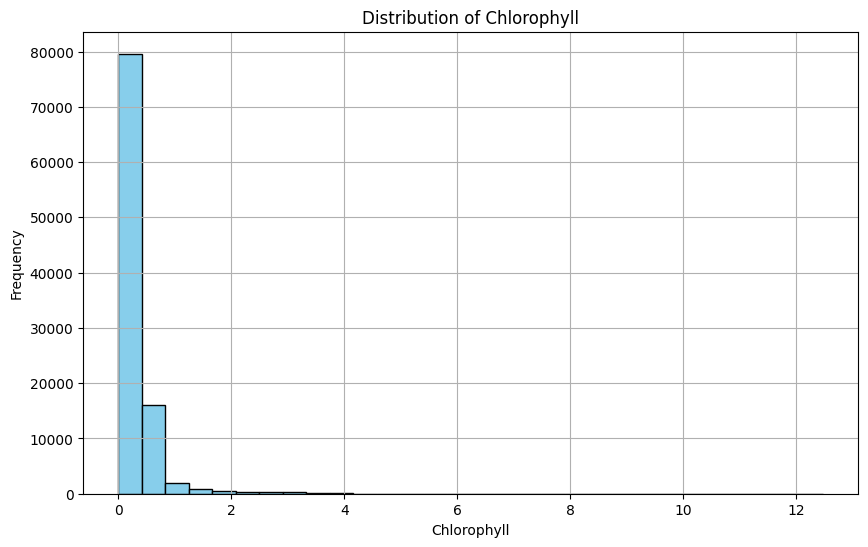

In [58]:


import pandas as pd
import matplotlib.pyplot as plt

# 讀取CSV文件
data = pd.read_csv("data/train_nn_filtered_data.csv")

# 確認數據的資訊
data.info()

# 顯示基本統計描述
print(data.describe())

# 顯示數據的形狀
print(data.shape)

# 顯示數據的欄位名稱
print(data.columns)

# 畫出Chlorophyll的分布圖
plt.figure(figsize=(10, 6))
plt.hist(data['Chlorophyll'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Chlorophyll')
plt.xlabel('Chlorophyll')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()







去除極端值

原始數據的描述性統計量:
count    100000.000000
mean          0.297009
std           0.428205
min           0.000000
25%           0.102731
50%           0.170470
75%           0.347012
max          12.477114
Name: Chlorophyll, dtype: float64

過濾後數據的描述性統計量:
count    99469.000000
mean         0.277050
std          0.314498
min          0.000000
25%          0.102511
50%          0.168969
75%          0.342920
max          2.999929
Name: Chlorophyll, dtype: float64


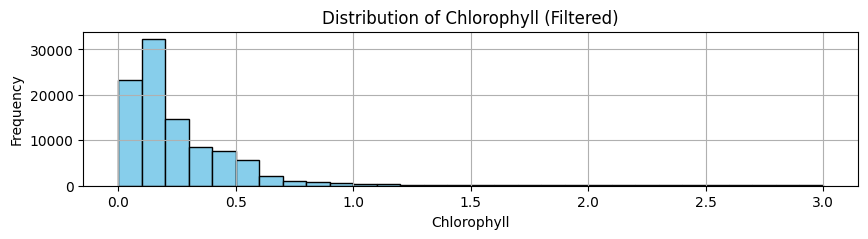

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取CSV文件
data = pd.read_csv("data/train_nn_filtered_data.csv")

# 顯示原始數據的描述性統計量
print("原始數據的描述性統計量:")
print(data['Chlorophyll'].describe())

# 去除Chlorophyll值大於6的極端值
data = data[data['Chlorophyll'] <= 3]

# 顯示過濾後數據的描述性統計量
print("\n過濾後數據的描述性統計量:")
print(data['Chlorophyll'].describe())

# 畫出過濾後Chlorophyll的分布圖
plt.figure(figsize=(10, 2))
plt.hist(data['Chlorophyll'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Chlorophyll (Filtered)')
plt.xlabel('Chlorophyll')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


count

In [60]:
print(data.Chlorophyll.count())
print(data.Albedo_01.count())
print(data.Albedo_02.count())
print(data.Albedo_03.count())
print(data.Albedo_04.count())

99469
99469
99469
99469
99469


資料預處理

In [61]:
train = data
train.info()
train.Chlorophyll.value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 99469 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Albedo_01    99469 non-null  float64
 1   Albedo_02    99469 non-null  float64
 2   Albedo_03    99469 non-null  float64
 3   Albedo_04    99469 non-null  float64
 4   Chlorophyll  99469 non-null  float64
dtypes: float64(5)
memory usage: 4.6 MB


Chlorophyll
0.084818    3
0.082852    3
0.135982    3
0.085117    3
0.096571    3
           ..
0.396150    1
0.099103    1
0.546180    1
0.092905    1
0.136695    1
Name: count, Length: 98794, dtype: int64

In [62]:
X = train.drop('Chlorophyll', axis=1)
y = train.Chlorophyll
y.value_counts()


Chlorophyll
0.084818    3
0.082852    3
0.135982    3
0.085117    3
0.096571    3
           ..
0.396150    1
0.099103    1
0.546180    1
0.092905    1
0.136695    1
Name: count, Length: 98794, dtype: int64

### 標準化數據

In [63]:
scaler = StandardScaler()
# scale the data to make it easier for the model to learn
X = scaler.fit_transform(X)


# 資料分割
test_ratio = 0.2
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_seed)

# 建立模型
xgb_model = xgb.XGBRegressor()
lgb_model = lgb.LGBMRegressor()
cb_model = cb.CatBoostRegressor(verbose=0)

# 訓練模型
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train)

# 預測
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

y_train_pred_lgb = lgb_model.predict(X_train)
y_test_pred_lgb = lgb_model.predict(X_test)

y_train_pred_cb = cb_model.predict(X_train)
y_test_pred_cb = cb_model.predict(X_test)

# 定義計算指標的函數
def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred):
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    return train_mae, test_mae, train_rmse, test_rmse, train_r2, test_r2

# 計算和打印指標
def print_metrics(model_name, metrics):
    train_mae, test_mae, train_rmse, test_rmse, train_r2, test_r2 = metrics
    print(f"{model_name} Performance:")
    print(f"Train MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
    print(f"Train R2: {train_r2}")
    print(f"Test R2: {test_r2}")
    print("-" * 30)

# XGBoost
metrics_xgb = calculate_metrics(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)
print_metrics("XGBoost", metrics_xgb)

# LightGBM
metrics_lgb = calculate_metrics(y_train, y_train_pred_lgb, y_test, y_test_pred_lgb)
print_metrics("LightGBM", metrics_lgb)

# CatBoost
metrics_cb = calculate_metrics(y_train, y_train_pred_cb, y_test, y_test_pred_cb)
print_metrics("CatBoost", metrics_cb)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 79575, number of used features: 4
[LightGBM] [Info] Start training from score 0.277291
XGBoost Performance:
Train MAE: 0.08036176115571639
Test MAE: 0.08736418640560088
Train RMSE: 0.15640860667620998
Test RMSE: 0.17715312979231704
Train R2: 0.7525148990763217
Test R2: 0.6834501652674765
------------------------------
LightGBM Performance:
Train MAE: 0.08634195514037009
Test MAE: 0.0881492964623694
Train RMSE: 0.16888929361942592
Test RMSE: 0.1743863517929382
Train R2: 0.7114427418306917
Test R2: 0.693260703931939
------------------------------
CatBoost Performance:
Train MAE: 0.08369699179829349
Test MAE: 0.08711942474161993
Train RMSE: 0.16154244882559815
Test RMSE: 0.173

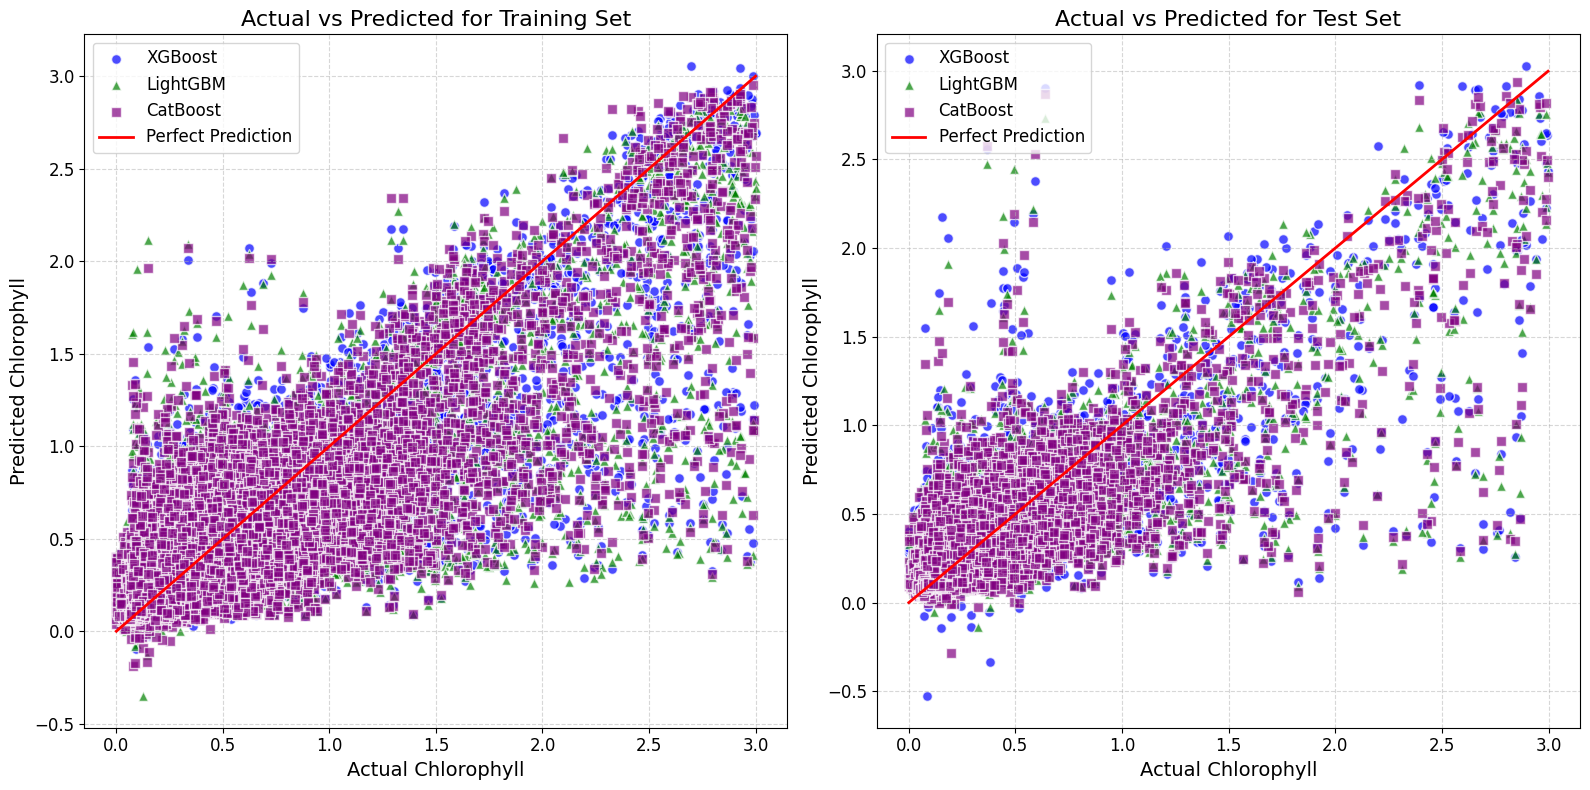

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# 假設 y_train, y_train_pred_xgb, y_train_pred_lgb, y_train_pred_cb, y_test, y_test_pred_xgb, y_test_pred_lgb, y_test_pred_cb 已經定義
# 替換為您實際的數據

def plot_results_overlay(y_train, y_train_pred_xgb, y_train_pred_lgb, y_train_pred_cb,
                         y_test, y_test_pred_xgb, y_test_pred_lgb, y_test_pred_cb):
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 增加圖表大小
    
    # 訓練集
    axes[0].scatter(y_train, y_train_pred_xgb, color='blue', alpha=0.7, edgecolors='w', s=50, label='XGBoost', marker='o')
    axes[0].scatter(y_train, y_train_pred_lgb, color='green', alpha=0.7, edgecolors='w', s=50, label='LightGBM', marker='^')
    axes[0].scatter(y_train, y_train_pred_cb, color='purple', alpha=0.7, edgecolors='w', s=50, label='CatBoost', marker='s')
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', linewidth=2.0, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Chlorophyll', fontsize=14)
    axes[0].set_ylabel('Predicted Chlorophyll', fontsize=14)
    axes[0].set_title('Actual vs Predicted for Training Set', fontsize=16)
    axes[0].legend(frameon=True, loc='upper left', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    
    # 測試集
    axes[1].scatter(y_test, y_test_pred_xgb, color='blue', alpha=0.7, edgecolors='w', s=50, label='XGBoost', marker='o')
    axes[1].scatter(y_test, y_test_pred_lgb, color='green', alpha=0.7, edgecolors='w', s=50, label='LightGBM', marker='^')
    axes[1].scatter(y_test, y_test_pred_cb, color='purple', alpha=0.7, edgecolors='w', s=50, label='CatBoost', marker='s')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', linewidth=2.0, label='Perfect Prediction')
    axes[1].set_xlabel('Actual Chlorophyll', fontsize=14)
    axes[1].set_ylabel('Predicted Chlorophyll', fontsize=14)
    axes[1].set_title('Actual vs Predicted for Test Set', fontsize=16)
    axes[1].legend(frameon=True, loc='upper left', fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()  # 調整佈局以防止標籤被切掉
    plt.show()

# 調用函數繪製結果
plot_results_overlay(y_train, y_train_pred_xgb, y_train_pred_lgb, y_train_pred_cb,
                     y_test, y_test_pred_xgb, y_test_pred_lgb, y_test_pred_cb)


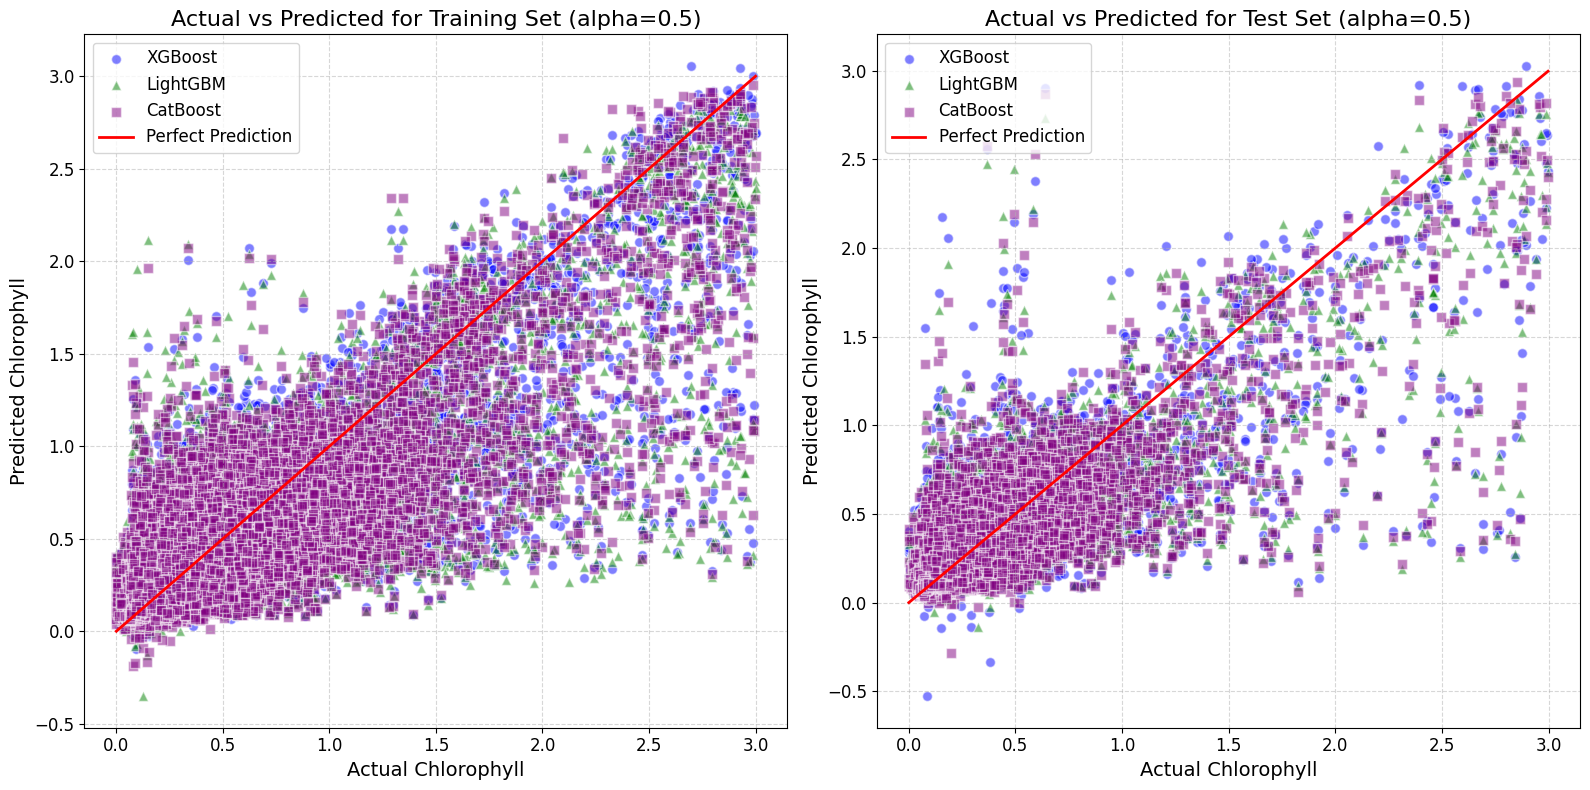

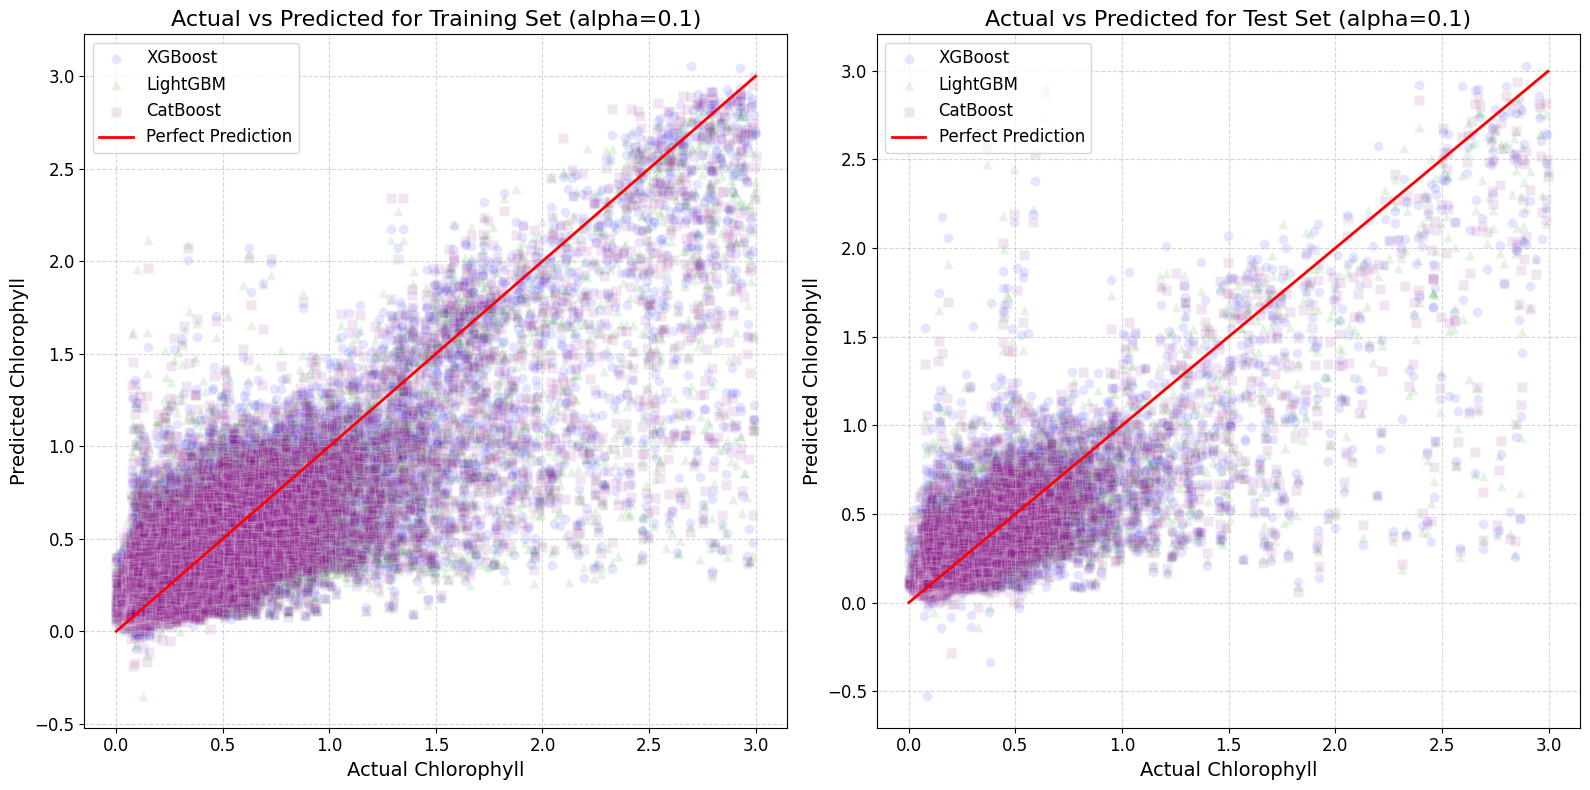

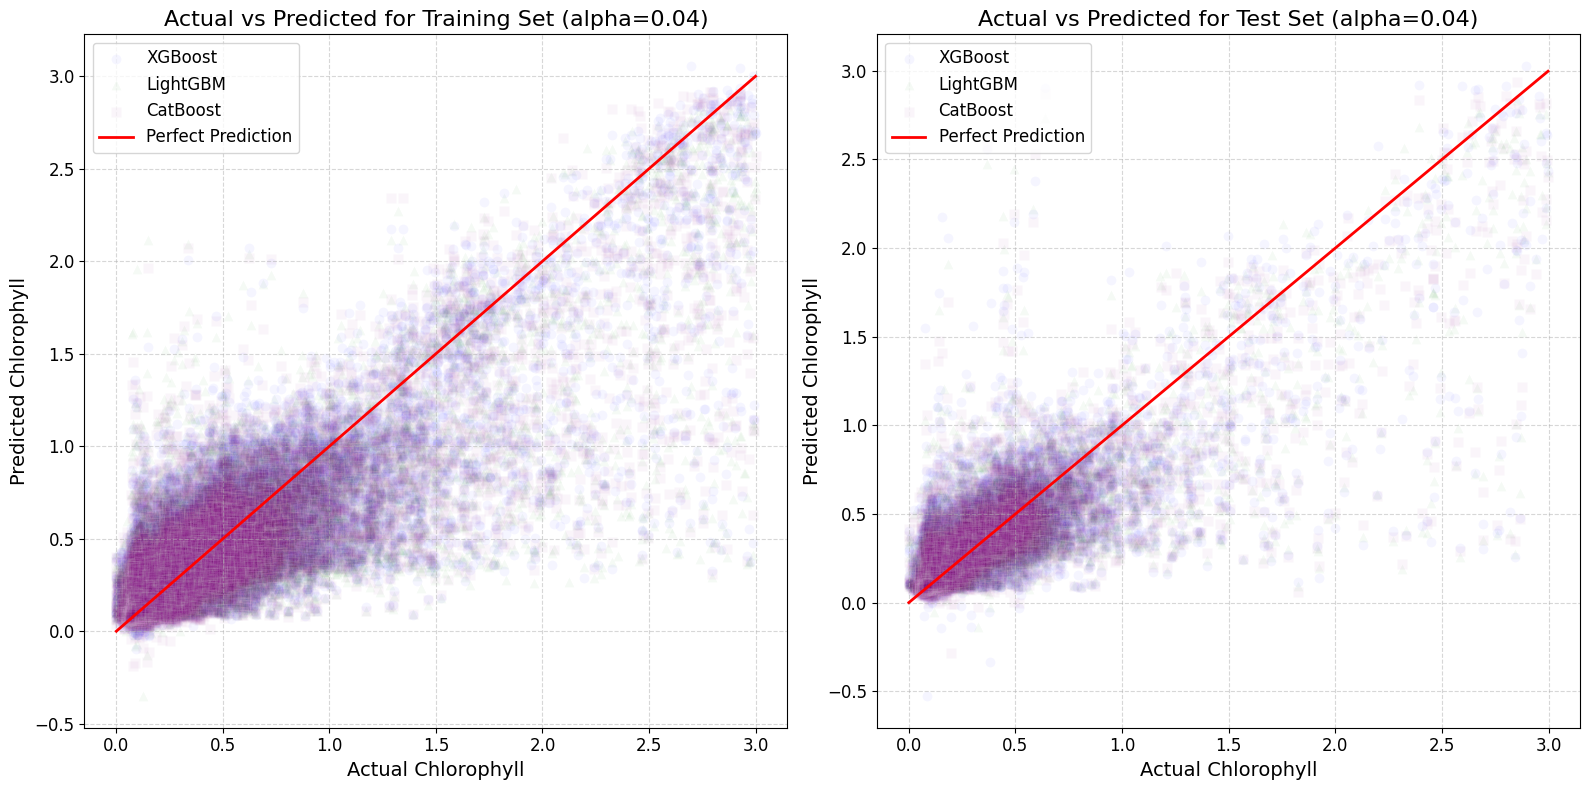

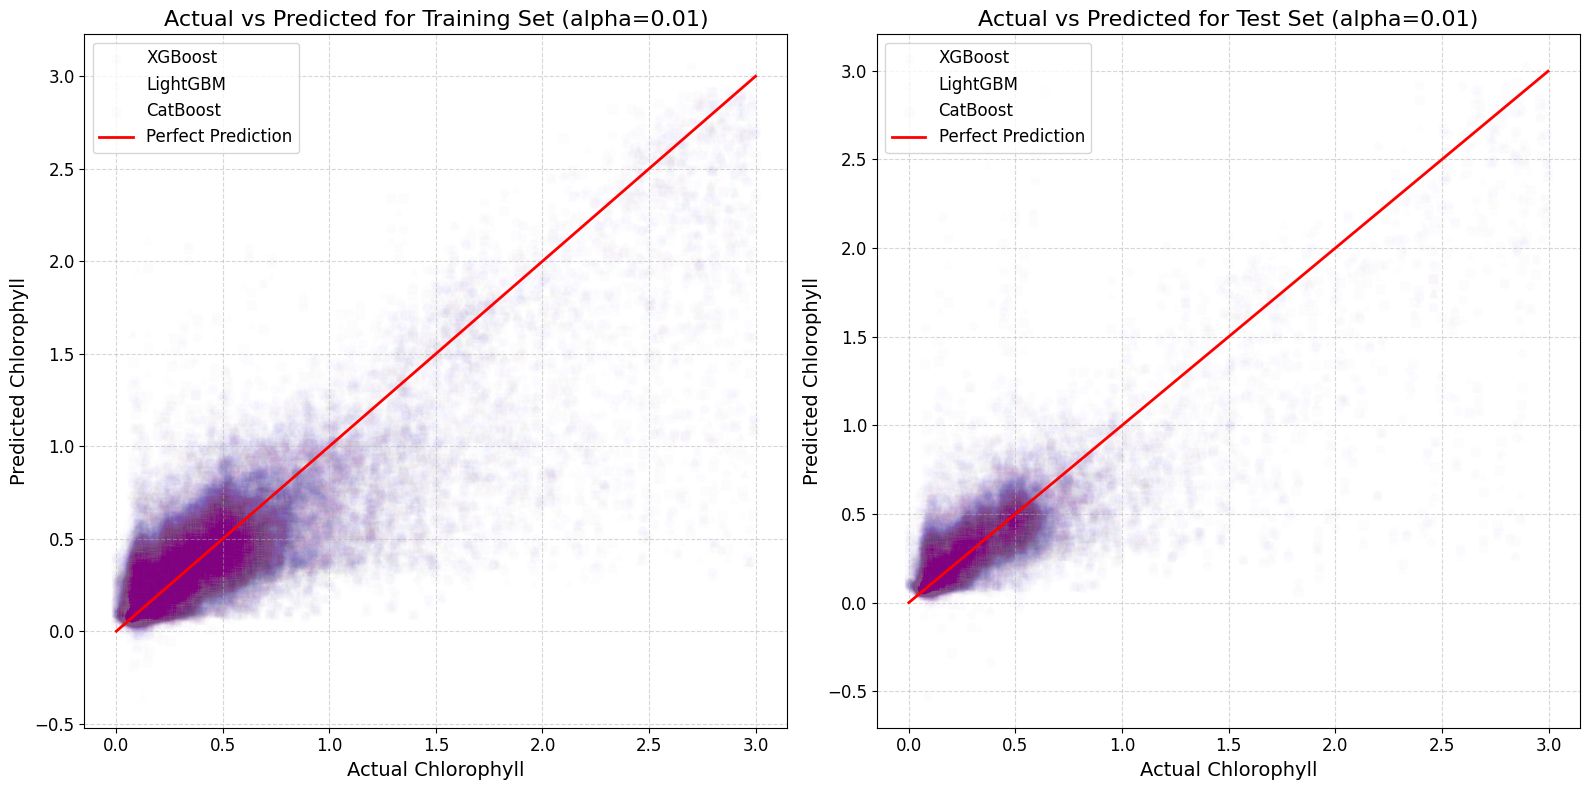

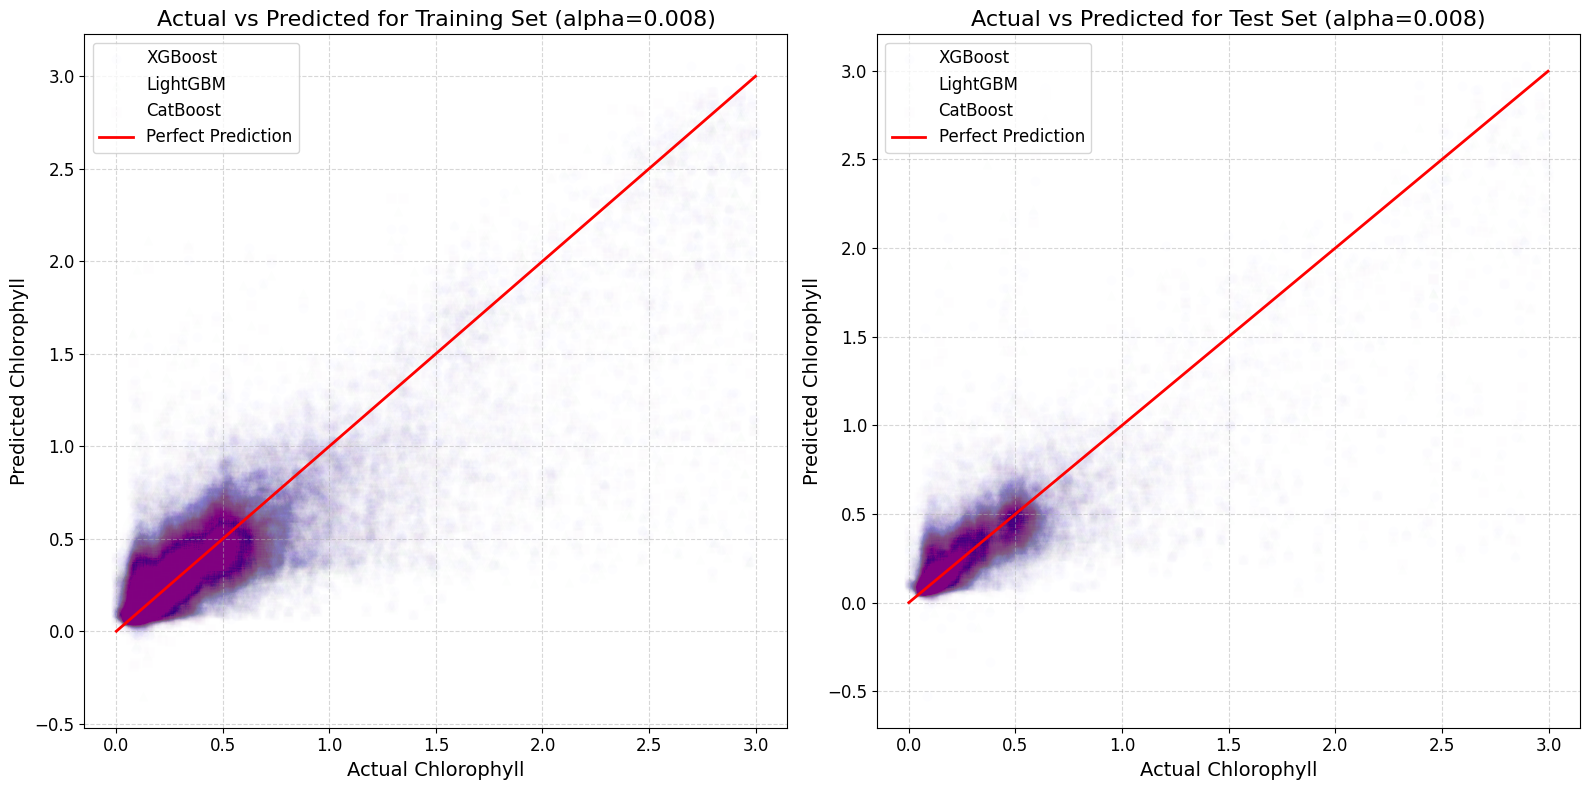

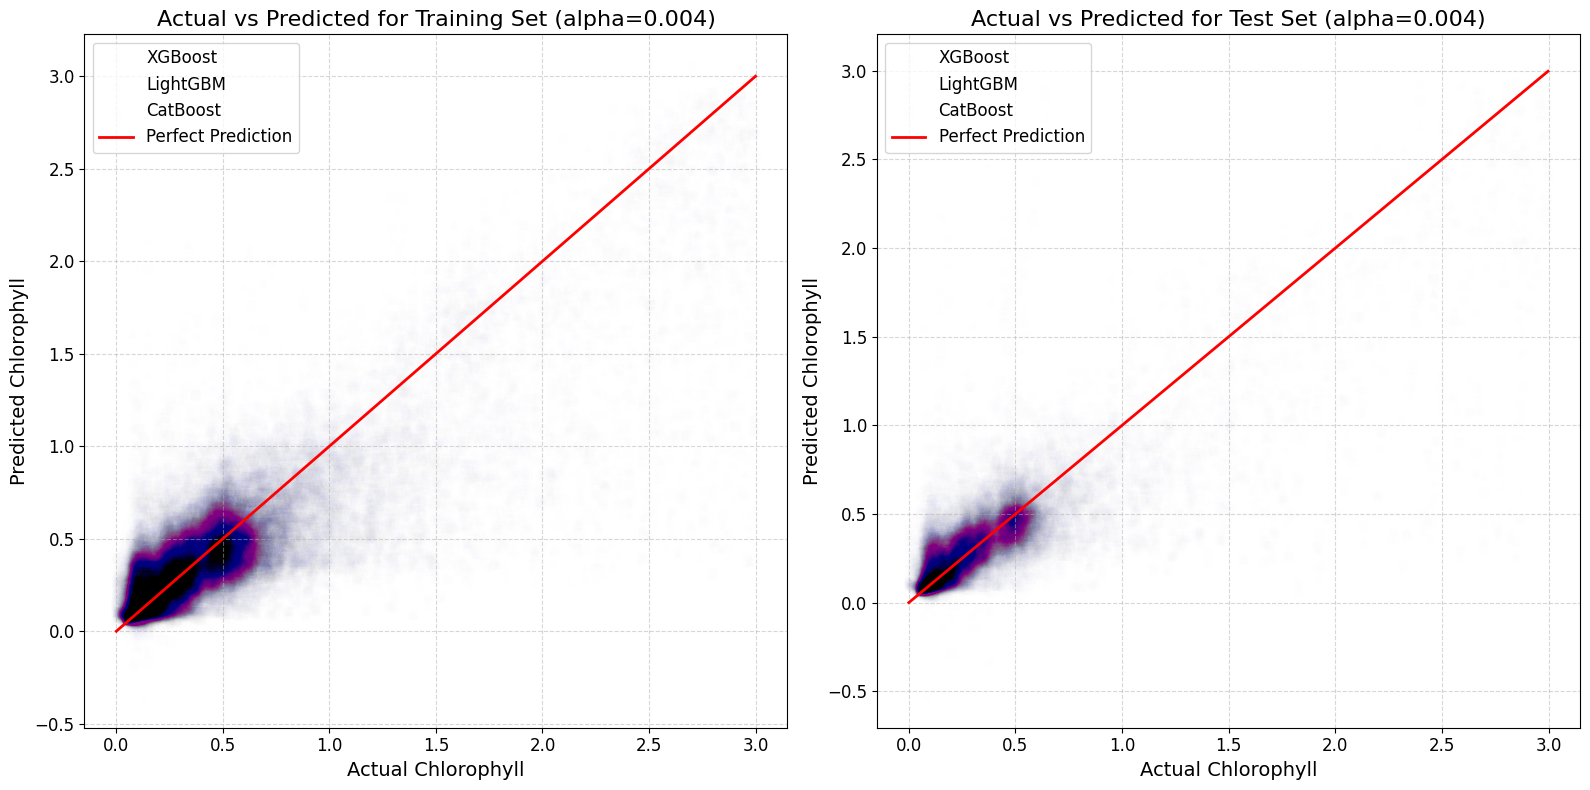

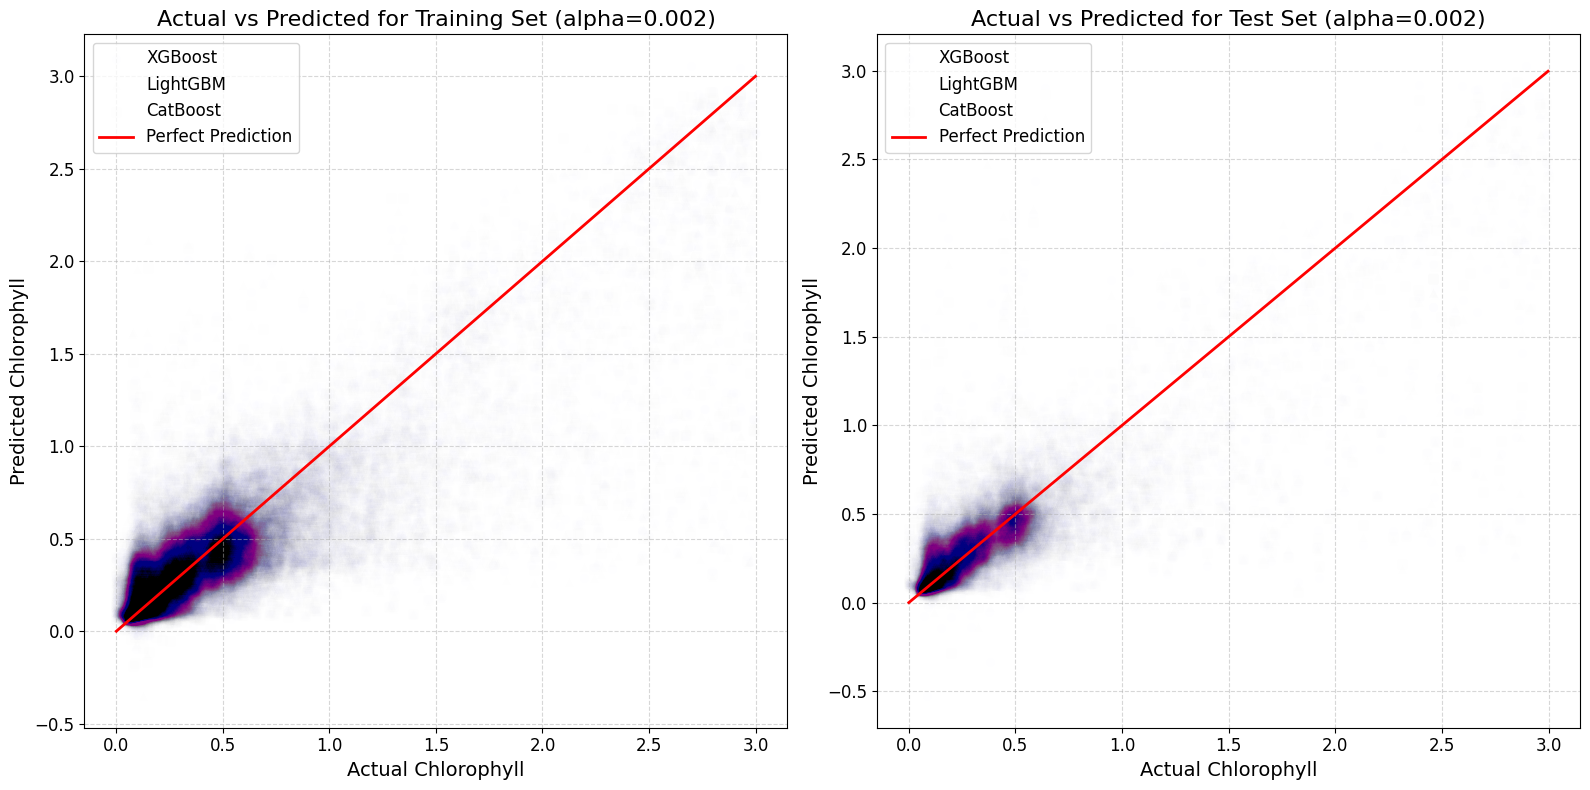

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# 假設 y_train, y_train_pred_xgb, y_train_pred_lgb, y_train_pred_cb, y_test, y_test_pred_xgb, y_test_pred_lgb, y_test_pred_cb 已經定義
# 替換為您實際的數據

def plot_results_overlay_with_alpha(y_train, y_train_pred_xgb, y_train_pred_lgb, y_train_pred_cb,
                                    y_test, y_test_pred_xgb, y_test_pred_lgb, y_test_pred_cb):
    
    alpha_values = [0.5, 0.1, 0.04, 0.01, 0.008, 0.004, 0.002]  # alpha值的列表
    
    for alpha in alpha_values:
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 增加圖表大小

        # 訓練集
        axes[0].scatter(y_train, y_train_pred_xgb, color='blue', alpha=alpha, edgecolors='w', s=50, label='XGBoost', marker='o')
        axes[0].scatter(y_train, y_train_pred_lgb, color='green', alpha=alpha, edgecolors='w', s=50, label='LightGBM', marker='^')
        axes[0].scatter(y_train, y_train_pred_cb, color='purple', alpha=alpha, edgecolors='w', s=50, label='CatBoost', marker='s')
        axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r-', linewidth=2.0, label='Perfect Prediction')
        axes[0].set_xlabel('Actual Chlorophyll', fontsize=14)
        axes[0].set_ylabel('Predicted Chlorophyll', fontsize=14)
        axes[0].set_title(f'Actual vs Predicted for Training Set (alpha={alpha})', fontsize=16)
        axes[0].legend(frameon=True, loc='upper left', fontsize=12)
        axes[0].grid(True, linestyle='--', alpha=0.5)
        axes[0].tick_params(axis='both', which='major', labelsize=12)

        # 測試集
        axes[1].scatter(y_test, y_test_pred_xgb, color='blue', alpha=alpha, edgecolors='w', s=50, label='XGBoost', marker='o')
        axes[1].scatter(y_test, y_test_pred_lgb, color='green', alpha=alpha, edgecolors='w', s=50, label='LightGBM', marker='^')
        axes[1].scatter(y_test, y_test_pred_cb, color='purple', alpha=alpha, edgecolors='w', s=50, label='CatBoost', marker='s')
        axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', linewidth=2.0, label='Perfect Prediction')
        axes[1].set_xlabel('Actual Chlorophyll', fontsize=14)
        axes[1].set_ylabel('Predicted Chlorophyll', fontsize=14)
        axes[1].set_title(f'Actual vs Predicted for Test Set (alpha={alpha})', fontsize=16)
        axes[1].legend(frameon=True, loc='upper left', fontsize=12)
        axes[1].grid(True, linestyle='--', alpha=0.5)
        axes[1].tick_params(axis='both', which='major', labelsize=12)

        plt.tight_layout()  # 調整佈局以防止標籤被切掉
        plt.show()

# 調用函數繪製不同alpha值的結果
plot_results_overlay_with_alpha(y_train, y_train_pred_xgb, y_train_pred_lgb, y_train_pred_cb,
                                y_test, y_test_pred_xgb, y_test_pred_lgb, y_test_pred_cb)
